In [1]:
import sys
import os
import configparser
import csv
import copy
import numpy as np
import imageio
import torch
import torchvision
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import roc_curve, auc
from RetinaCheckerCSV import RetinaCheckerCSV
from helper_functions import reduce_to_2_classes, AverageMeter, AccuracyMeter
from make_default_config import get_config


In [2]:
# parameter
config = get_config()
config['network']['model'] = 'inception_v3'
config['network']['pretrained'] = 'False'
config['network']['optimizer'] = 'Adam'
config['network']['criterion'] = 'BCEWithLogitsLoss'
config['network']['multiclass'] = 'True'

config['files']['label file'] = 'D:/Dropbox/Data/cropped-outer-test/labels.csv'
config['files']['test path'] = 'D:/Dropbox/Data/cropped-outer-test/'
config['files']['image size'] = '299'
config['input']['checkpoint'] = 'model_181112_inc_csv_after_epoch_21.ckpt'
config['input']['evaluation only'] = 'True'

number_sample_images = 36
max_batch_size = 16

In [3]:
    
rc = RetinaCheckerCSV()
rc.model_kwargs['aux_logits'] = False
rc.initialize( config )


Using device cpu


In [4]:
rc.load_state()

=> loaded checkpoint 'model_181112_inc_csv_after_epoch_21.ckpt' (epoch 21)


In [5]:
test_loader = torch.utils.data.DataLoader(dataset=rc.test_dataset,
                                        batch_size=min(len(rc.test_dataset), max_batch_size),
                                        shuffle=True,
                                        sampler=None)

In [6]:
all_outputs = np.zeros((len(rc.test_dataset), len(rc.classes)))
all_labels = np.zeros_like(all_outputs)

In [7]:
rc.model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    losses = AverageMeter()
    accuracy = AccuracyMeter()

    confusion = torch.zeros((2, 2), dtype=torch.float)
    confusion_old = torch.zeros((5, 5), dtype=torch.float)
    counter = 0
    
    for images, labels in test_loader:
        print('.', end='', flush=True)
        images = images.to(rc.device)
        labels = labels.to(rc.device)

        outputs = rc.model(images)
        loss = rc.criterion(outputs, labels)
        
        all_outputs[counter:counter+len(images), :] = outputs
        all_labels[counter:counter+len(images), :] = labels
        counter += len(images)

        losses.update(loss.item(), images.size(0))

        num_correct = rc._evaluate_performance( labels, outputs )

        accuracy.update(num_correct, labels.size(0))
        predicted = torch.nn.Sigmoid()(outputs)
        
        for pred, lab in zip(predicted[:,5].round().cpu().numpy().astype(np.int), labels[:,5].cpu().numpy().astype(np.int)):
            confusion[pred, lab] += 1
        for pred, lab in zip(predicted[:,:5].argmax(1), labels[:,:5].argmax(1)):
            confusion_old[pred, lab] += 1


..........

In [8]:
print('Test Accuracy of the model on the {} test images: {} %'.format(accuracy.count, accuracy.avg*100))
print('Classes: {}'.format(5))
print('Confusion matrix:\n', (confusion_old))

confusion_2class = confusion
print('Accuracy: {:.1f}%'.format(np.diag(confusion_2class).sum()/confusion_2class.sum()*100))
print(confusion_2class)
print('Sensitivity: {:.1f}%'.format(confusion_2class[1,1]/confusion_2class[:,1].sum()*100))
print('Specificity: {:.1f}%'.format(confusion_2class[0,0]/confusion_2class[:,0].sum()*100))

Test Accuracy of the model on the 150 test images: 92.66666666666666 %
Classes: 5
Confusion matrix:
 tensor([[29., 15.,  4.,  0.,  0.],
        [ 1., 14.,  4.,  0.,  0.],
        [ 0.,  1., 13.,  2.,  3.],
        [ 0.,  0.,  4., 28., 20.],
        [ 0.,  0.,  5.,  0.,  7.]])
Accuracy: 92.7%
tensor([[58.,  9.],
        [ 2., 81.]])
Sensitivity: 90.0%
Specificity: 96.7%


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
max_samples = min(len(rc.test_dataset), number_sample_images)

if max_samples < len(rc.test_dataset):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=max_samples)
    sampling_index = next(iter(sss.split([img[0] for img in rc.test_dataset.imgs], [img[1][:5].argmax() for img in rc.test_dataset.imgs])))[1]
else:
    sampling_index = np.arange(len(rc.test_dataset), dtype=np.int)

In [11]:
dataset = copy.deepcopy(rc.test_dataset)
dataset.imgs = [dataset.imgs[ii] for ii in sampling_index]
dataset.samples = dataset.imgs
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                                    batch_size=min(len(dataset), max_batch_size),
                                    shuffle=False,
                                    sampler=None)

In [ ]:
font_size = 8
if number_sample_images > 0:  
    n_cols = 6
    n_rows = np.ceil(number_sample_images/n_cols)
    classlabel = ['no DMR', 'mild NPDR', 'mod NPDR', 'severe NPDR', 'PDR', '>=mod', '>=severe']
    fig, ax = plt.subplots(int(n_rows), int(n_cols), True, True, figsize=(20,int(n_rows)*3))
    counter = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(rc.device)
            labels = labels.to(rc.device)

            outputs = rc.model(images)

            for img, lab, out in zip(images, labels, outputs):
                ii = int(counter/n_cols)
                jj = int(counter%n_cols)
                img_array = skimage.transform.resize(imageio.imread(dataset.imgs[counter][0]), (224,224), mode='constant', anti_aliasing=True)
                ax[ii, jj].imshow(img_array, origin='lower')
                ax[ii, jj].annotate( classlabel[lab[:5].argmax()], xy=(10,10), color='white', size=font_size)
                prediction = torch.nn.Sigmoid()(out)
                if prediction[5] > 0.5:
                    ax[ii, jj].annotate( '>=mod', xy=(120,10), color='cyan', size=font_size)
                else:
                    ax[ii, jj].annotate( 'not ref', xy=(120,10), color='cyan', size=font_size)
                if (lab[:5].argmax() < 2 and prediction[5] >= 0.5) or (lab[:5].argmax() >= 2 and prediction[5] < 0.5):
                    ax[ii, jj].annotate( 'X', xy=(200,200), color='red', size=20)
                for cc in range(7):
                    ax[ii, jj].annotate( '{}: {:.3f}'.format(classlabel[cc], prediction[cc]) , xy=(10,205-cc*2*font_size), color='white', size=font_size)
                counter+=1

    plt.xticks([])
    plt.yticks([])

In [12]:
y_test = all_labels
y_score = all_outputs
n_classes = 7

In [13]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

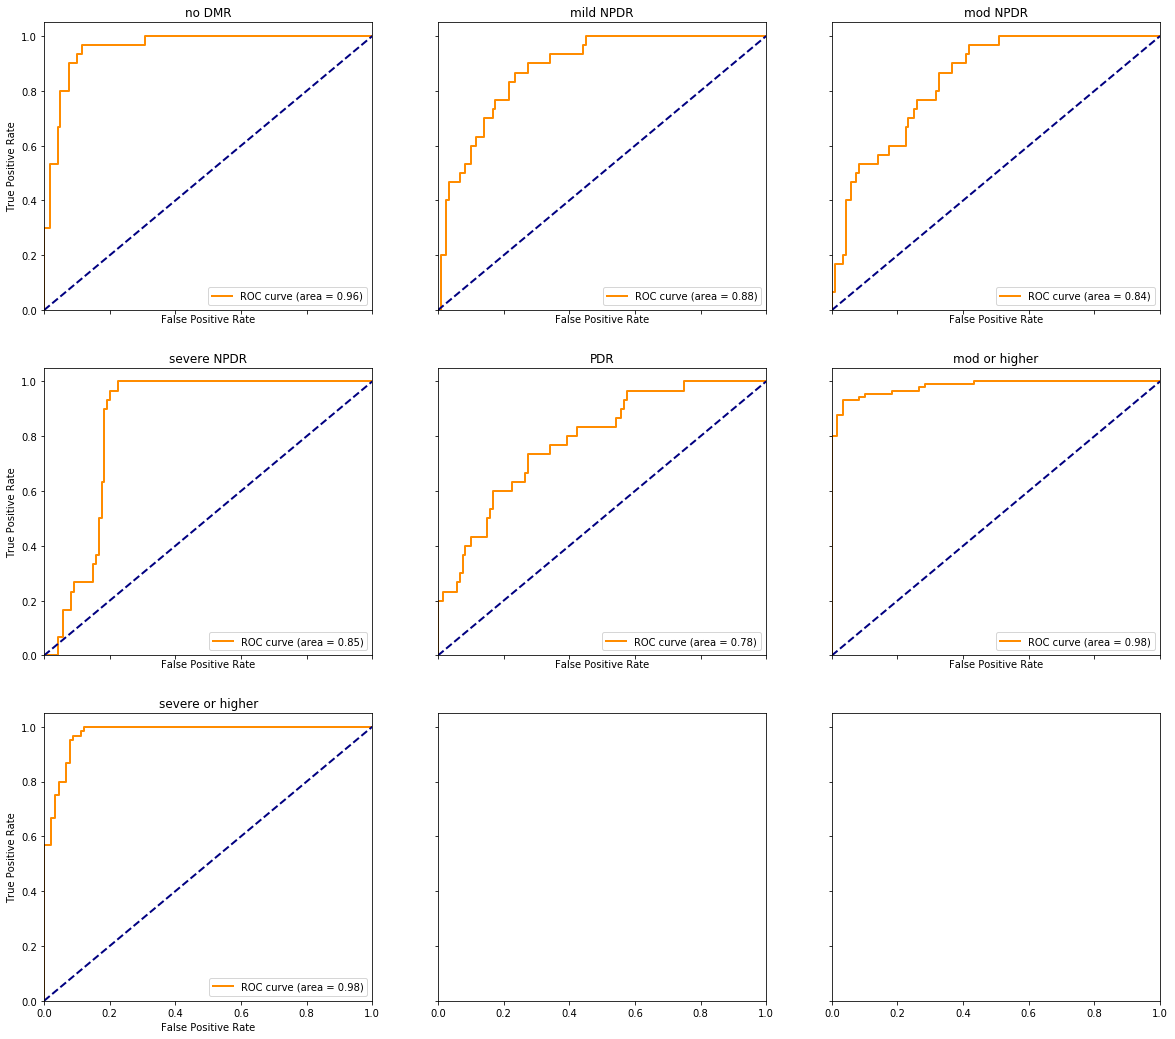

In [21]:
n_cols = 3
n_rows = int(np.ceil(n_classes/n_cols))
fig, ax = plt.subplots(n_rows, n_cols, True, True, figsize=(20,6*n_rows))
lw = 2
for ii in range(n_classes):
    row = int(ii/n_cols)
    col = int(ii%n_cols)
    ax[row, col].plot(fpr[ii], tpr[ii], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[ii])
    ax[row, col].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[row, col].set_xlim([0.0, 1.0])
    ax[row, col].set_ylim([0.0, 1.05])
    ax[row, col].set_xlabel('False Positive Rate')
    ax[row, col].legend(loc="lower right")
    ax[row, col].set_title(dataset.classes[ii])
    ax[row, 0].set_ylabel('True Positive Rate')

plt.show()